# 대응 표본 T-검정 (Paired T-test)

표본의 각 사례마다 대응하는 2개의 관측치를 통해 판단

한 집단에 어떤 작용이 가해졌을 때에 대한 before, after를 비교

'related samples t-test' 또는 'paired samples t-test'로 부른다.

## #01. 준비작업

### [1] 패키지 참조

In [1]:
import warnings
warnings.filterwarnings(action='ignore')

import sys
import seaborn as sb
from math import sqrt
from pandas import read_excel, melt
from matplotlib import pyplot as plt
from scipy.stats import t, normaltest, bartlett, levene, ttest_rel, mannwhitneyu
from statannotations.Annotator import Annotator

### [2] 그래프 초기화

In [2]:
plt.rcParams["font.family"] = 'AppleGothic' if sys.platform == 'darwin' else 'Malgun Gothic'
plt.rcParams["font.size"] = 9
plt.rcParams["figure.figsize"] = (15, 6)
plt.rcParams["axes.unicode_minus"] = False

## #02. 예제 (1) - 사슴의 다리 길이 비교

사슴의 왼쪽 앞다리와 왼쪽 뒷다리의 길이를 측정한 자료를 통해 두 다리의 길이(cm)가 같은지 다른지 알고 싶다.

이 경우 한 사슴에 대하여 두 다리 길이를 측정하였으므로 사슴은 독립이지만 한 마리의 사슴의 일부인 두 다리는 독립이 아니다.

### [1] 데이터 가져오기

In [4]:
origin = read_excel("https://data.hossam.kr/mldata/deer.xlsx", index_col="사슴")
origin

,앞다리,뒷다리
사슴,,
1,138,142
2,136,140
3,147,144
4,139,144
5,143,142
6,141,146
7,143,149
8,145,150
9,136,142


### [2] 신뢰구간 확인

두 변수의 데이터 분포와 신뢰구간을 확인한다.

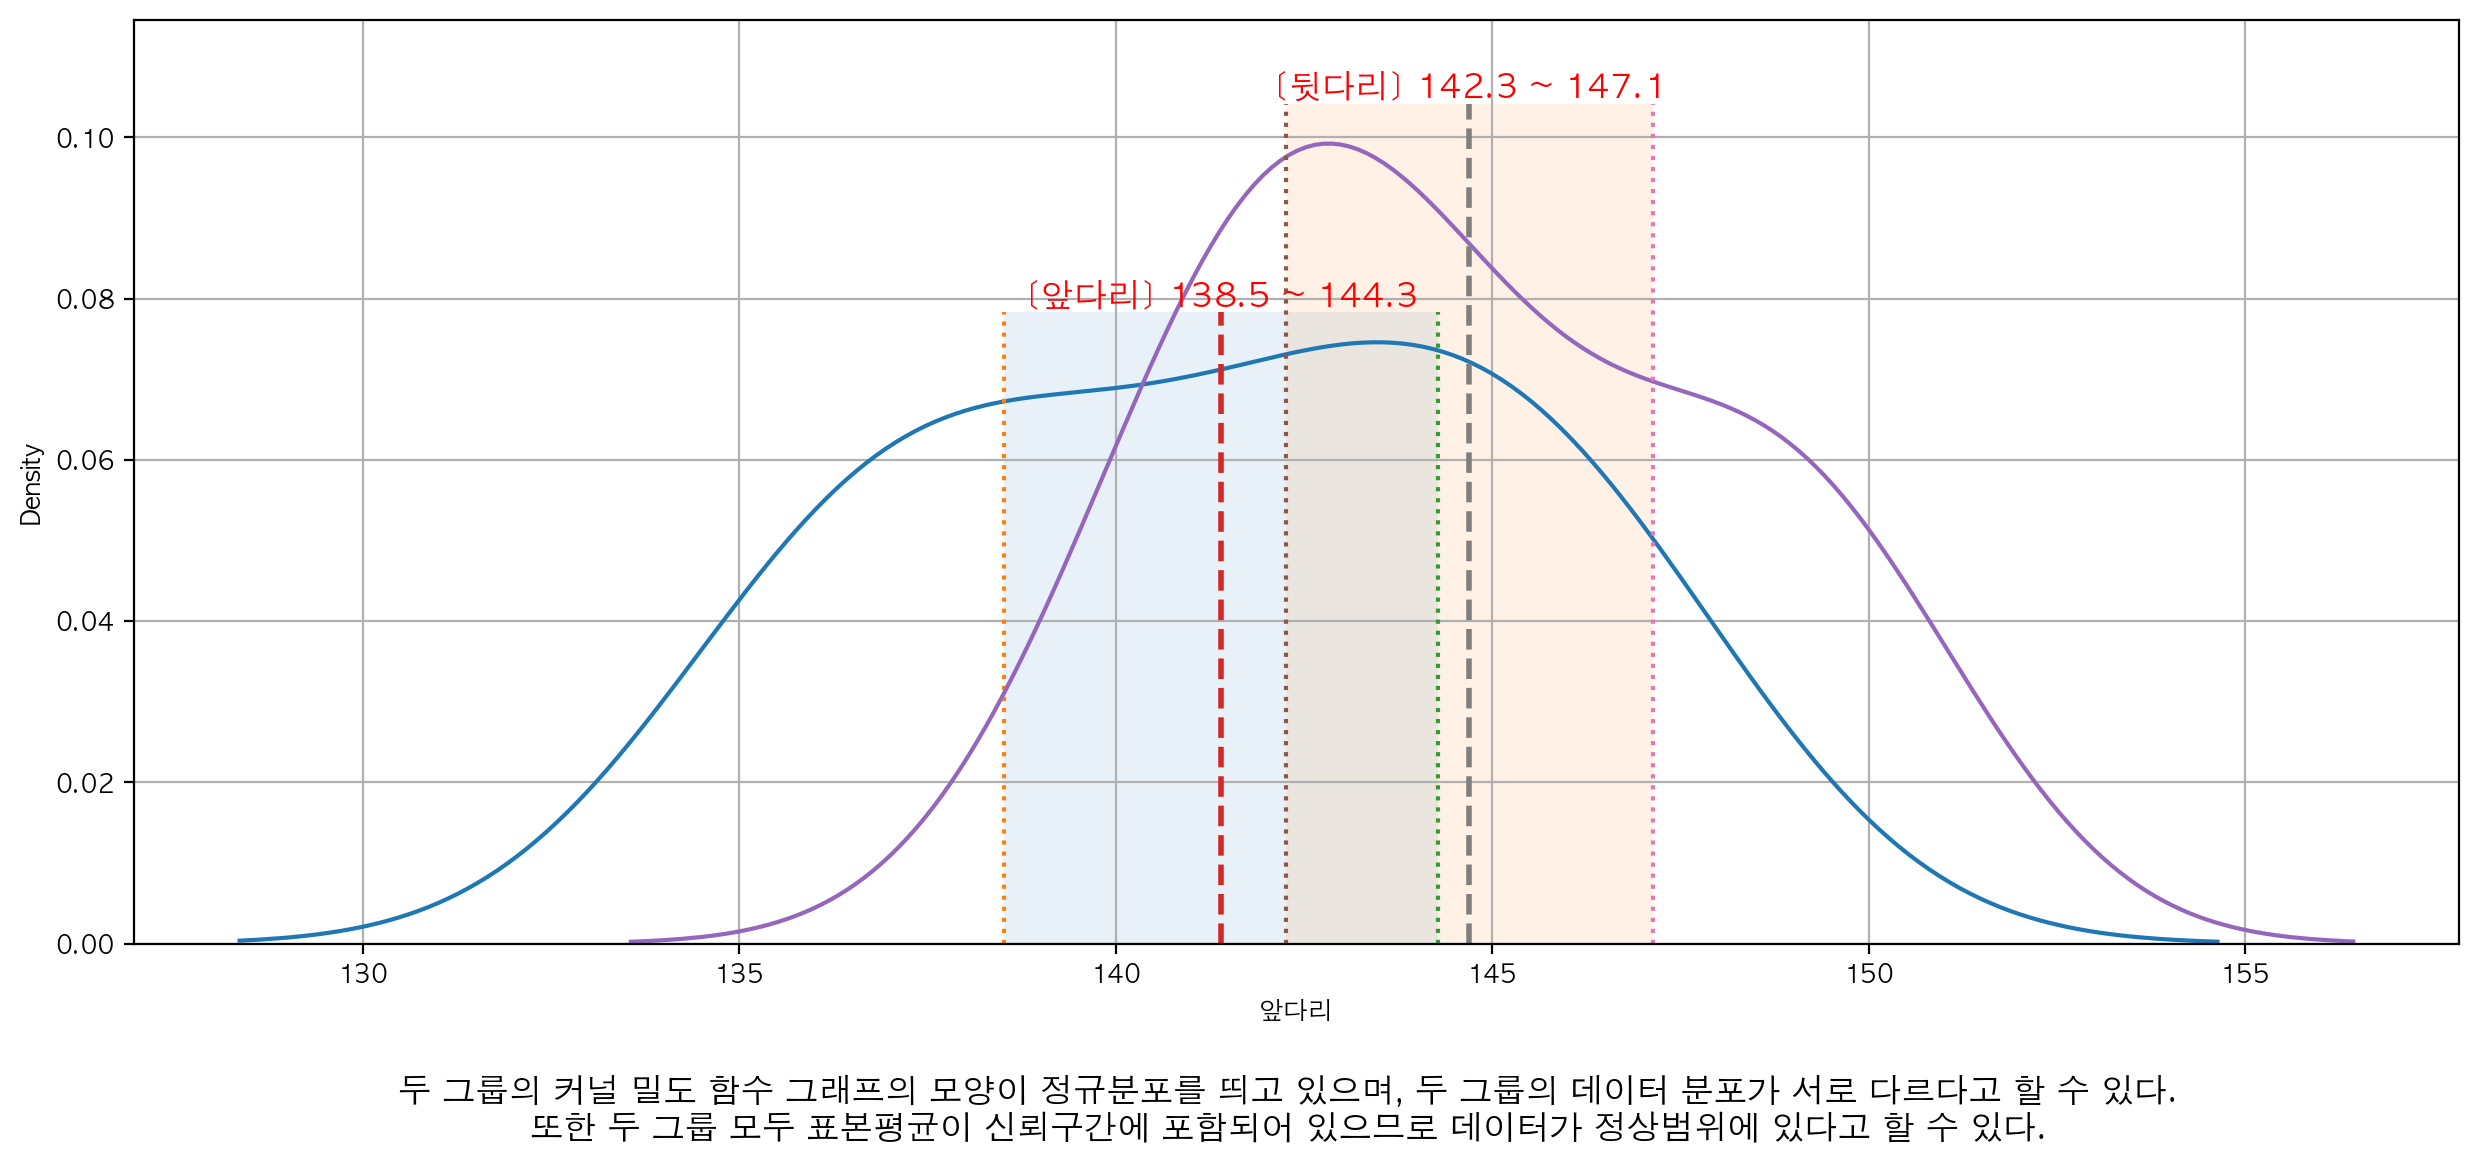

In [121]:
plt.figure()

for c in origin.columns:
    #print(c)
    
    data = origin[c]                                # 데이터만 추출
    max = data.max()                                # 최대값
    clevel = 0.95                                   # 신뢰수준
    dof = len(data) - 1                             # 자유도
    sample_mean = data.mean()                       # 표본평균
    sample_std = data.std(ddof=1)                   # 표본표준편차
    sample_std_error = sample_std / sqrt(len(data)) # 표본표준오차
    
    # 신뢰구간
    cmin, cmax = t.interval(clevel, dof, loc=sample_mean, scale=sample_std_error)

    sb.kdeplot(data=data)

    xmin, xmax, ymin, ymax = plt.axis()

    # 신뢰구간 그리기
    plt.plot([cmin, cmin], [0, ymax], linestyle=':')
    plt.plot([cmax, cmax], [0, ymax], linestyle=':')
    plt.fill_between([cmin, cmax], y1=0, y2=ymax, alpha=0.1)

    # 평균 그리기
    plt.plot([sample_mean, sample_mean], [0, ymax], linestyle='--', linewidth=2)

    plt.text(x=(cmax-cmin)/2+cmin,
            y=ymax,
            s="[%s] %0.1f ~ %0.1f" % (c, cmin, cmax),
            horizontalalignment="center",
            verticalalignment="bottom",
            fontdict={"size": 12, "color": "red"})
    
txt = """두 그룹의 커널 밀도 함수 그래프의 모양이 정규분포를 띄고 있으며, 두 그룹의 데이터 분포가 서로 다르다고 할 수 있다.
또한 두 그룹 모두 표본평균이 신뢰구간에 포함되어 있으므로 데이터가 정상범위에 있다고 할 수 있다."""

plt.figtext(0.51, 0, txt, wrap=True,
            verticalalignment="top", horizontalalignment="center",
            fontdict={"size": 12, "weight": "light"})

plt.ylim(0, ymax*1.1)
plt.grid()
plt.show()
plt.close()

### [3] 가설검정의 가정 확인

#### (1) 정규성

In [122]:
for c in origin.columns:
    s, p = normaltest(origin[c])
    print("[{0}] statistic: {1:.3f}, p-value: {2:.3f}, 정규성 충족 여부: {3}".format(c, s, p, p > 0.05))

[앞다리] statistic: 1.824, p-value: 0.402, 정규성 충족 여부: True
[뒷다리] statistic: 1.377, p-value: 0.502, 정규성 충족 여부: True


#### (2) 등분산성

In [123]:
normal_dist = True      # 정규성 만족 여부
data = origin.copy()    # 원본 데이터 복사
fields = list(map(lambda x: data[x], data.columns))

if normal_dist:
    n = "Bartlett"
    s, p = bartlett(*fields)
else:
    n = "Levene"
    s, p = levene(*fields)
    
print("{0} 검정: statistic: {1:.3f}, p-value: {2:.3f}, 등분산성 충족 여부: {3}".format(n, s, p, p > 0.05))

Bartlett 검정: statistic: 0.247, p-value: 0.619, 등분산성 충족 여부: True


> 가즈아~!!

### [4] 사슴의 앞다리와 뒷다리의 길이가 다른지 검정

| 구분 | 수식 | 내용 |
|---|---|---|
| 앞다리 | $\mu(앞다리)$ | |
| 뒷다리 | $\mu(뒷다리)$ | |
| 귀무가설($H_0$) | $\mu(앞다리) = \mu(뒷다리)$ | 사슴의 앞다리와 뒷다리 길이에는 차이가 없다 |
| 대립가설($H_1$) | $\mu(앞다리) \neq \mu(뒷다리)$ | 사슴의 앞다리와 뒷다리 길이에는 차이가 있다 |

두 그룹간의 평균을 비교하기 위해서는 `alternative` 파라미터를 `two-sided`로 설정해야 한다.

In [124]:
s, p = ttest_rel(origin['앞다리'], origin['뒷다리'], alternative='two-sided')
"statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택".format(s, p, "대립" if p <= 0.05 else "귀무")

'statistic: -3.414, p-value: 0.008, 대립가설 채택'

> 차이값에 대한 t 통계량의 값이 `-3.414`이고 이에 대응되는 유의확률이 `0.008`이므로 ($p < 0.05$)` 귀무가설을 기각하고 대립가설을 채택한다.
>
> 즉, 사슴의 앞다리와 뒷다리의 길이에는 차이가 있다고 결론 내릴 수 있다.

### [5] 앞다리가 뒷다리보다 더 긴지 검정

| 구분 | 수식 | 내용 |
|---|---|---|
| 귀무가설($H_0$) | $\mu(B) \leqq \mu(G)$ | 사슴의 앞다리는 뒷다리보다 길지 않다 |
| 대립가설($H_1$) | $\mu(B) > \mu(G)$ | 사슴의 앞다리는 뒷다리보다 길다 |

In [125]:
s, p = ttest_rel(origin['앞다리'], origin['뒷다리'], alternative='greater')
"statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택".format(s, p, "대립" if p <= 0.05 else "귀무")

'statistic: -3.414, p-value: 0.996, 귀무가설 채택'

> 차이값에 대한 t 통계량의 값이 `-3.414`이고 이에 대응되는 유의확률이 `0.996`이므로($p \geq 0.05$) 귀무가설을 기각할 수 없다.
> 
> 즉, 앞다리는 뒷다리보다 길지 않다고 결론 내릴 수 있다.

### [6] 앞다리가 뒷다리보다 더 짧은지 검정

| 구분 | 수식 | 내용 |
|---|---|---|
| 귀무가설($H_0$) | $\mu(B) \geqq \mu(G)$ | 사슴의 앞다리는 뒷다리보다 짧지 않다 |
| 대립가설($H_1$) | $\mu(B) < \mu(G)$ | 사슴의 앞다리는 뒷다리보다 짧다 |

In [126]:
s, p = ttest_rel(origin['앞다리'], origin['뒷다리'], alternative='less')
"statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택".format(s, p, "대립" if p <= 0.05 else "귀무")

'statistic: -3.414, p-value: 0.004, 대립가설 채택'

> 차이값에 대한 t 통계량의 값이 `3.414`이고 이에 대응되는 유의확률이 `0.004`이므로 ($p < 0.05$)` 귀무가설을 기각하고 대립가설을 채택한다.
>
> 즉, 사슴의 앞다리는 사슴의 뒷다리보다 짧다고 할 수 있다.

### [7] 가설검정 시각화

In [127]:
df = melt(origin, var_name='group', value_name='value')
df

,group,value
0,앞다리,138
1,앞다리,136
2,앞다리,147
3,앞다리,139
4,앞다리,143
5,앞다리,141
6,앞다리,143
7,앞다리,145
8,앞다리,136
9,앞다리,146


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

앞다리 vs. 뒷다리: t-test paired samples, P_val:7.703e-03 t=-3.414e+00


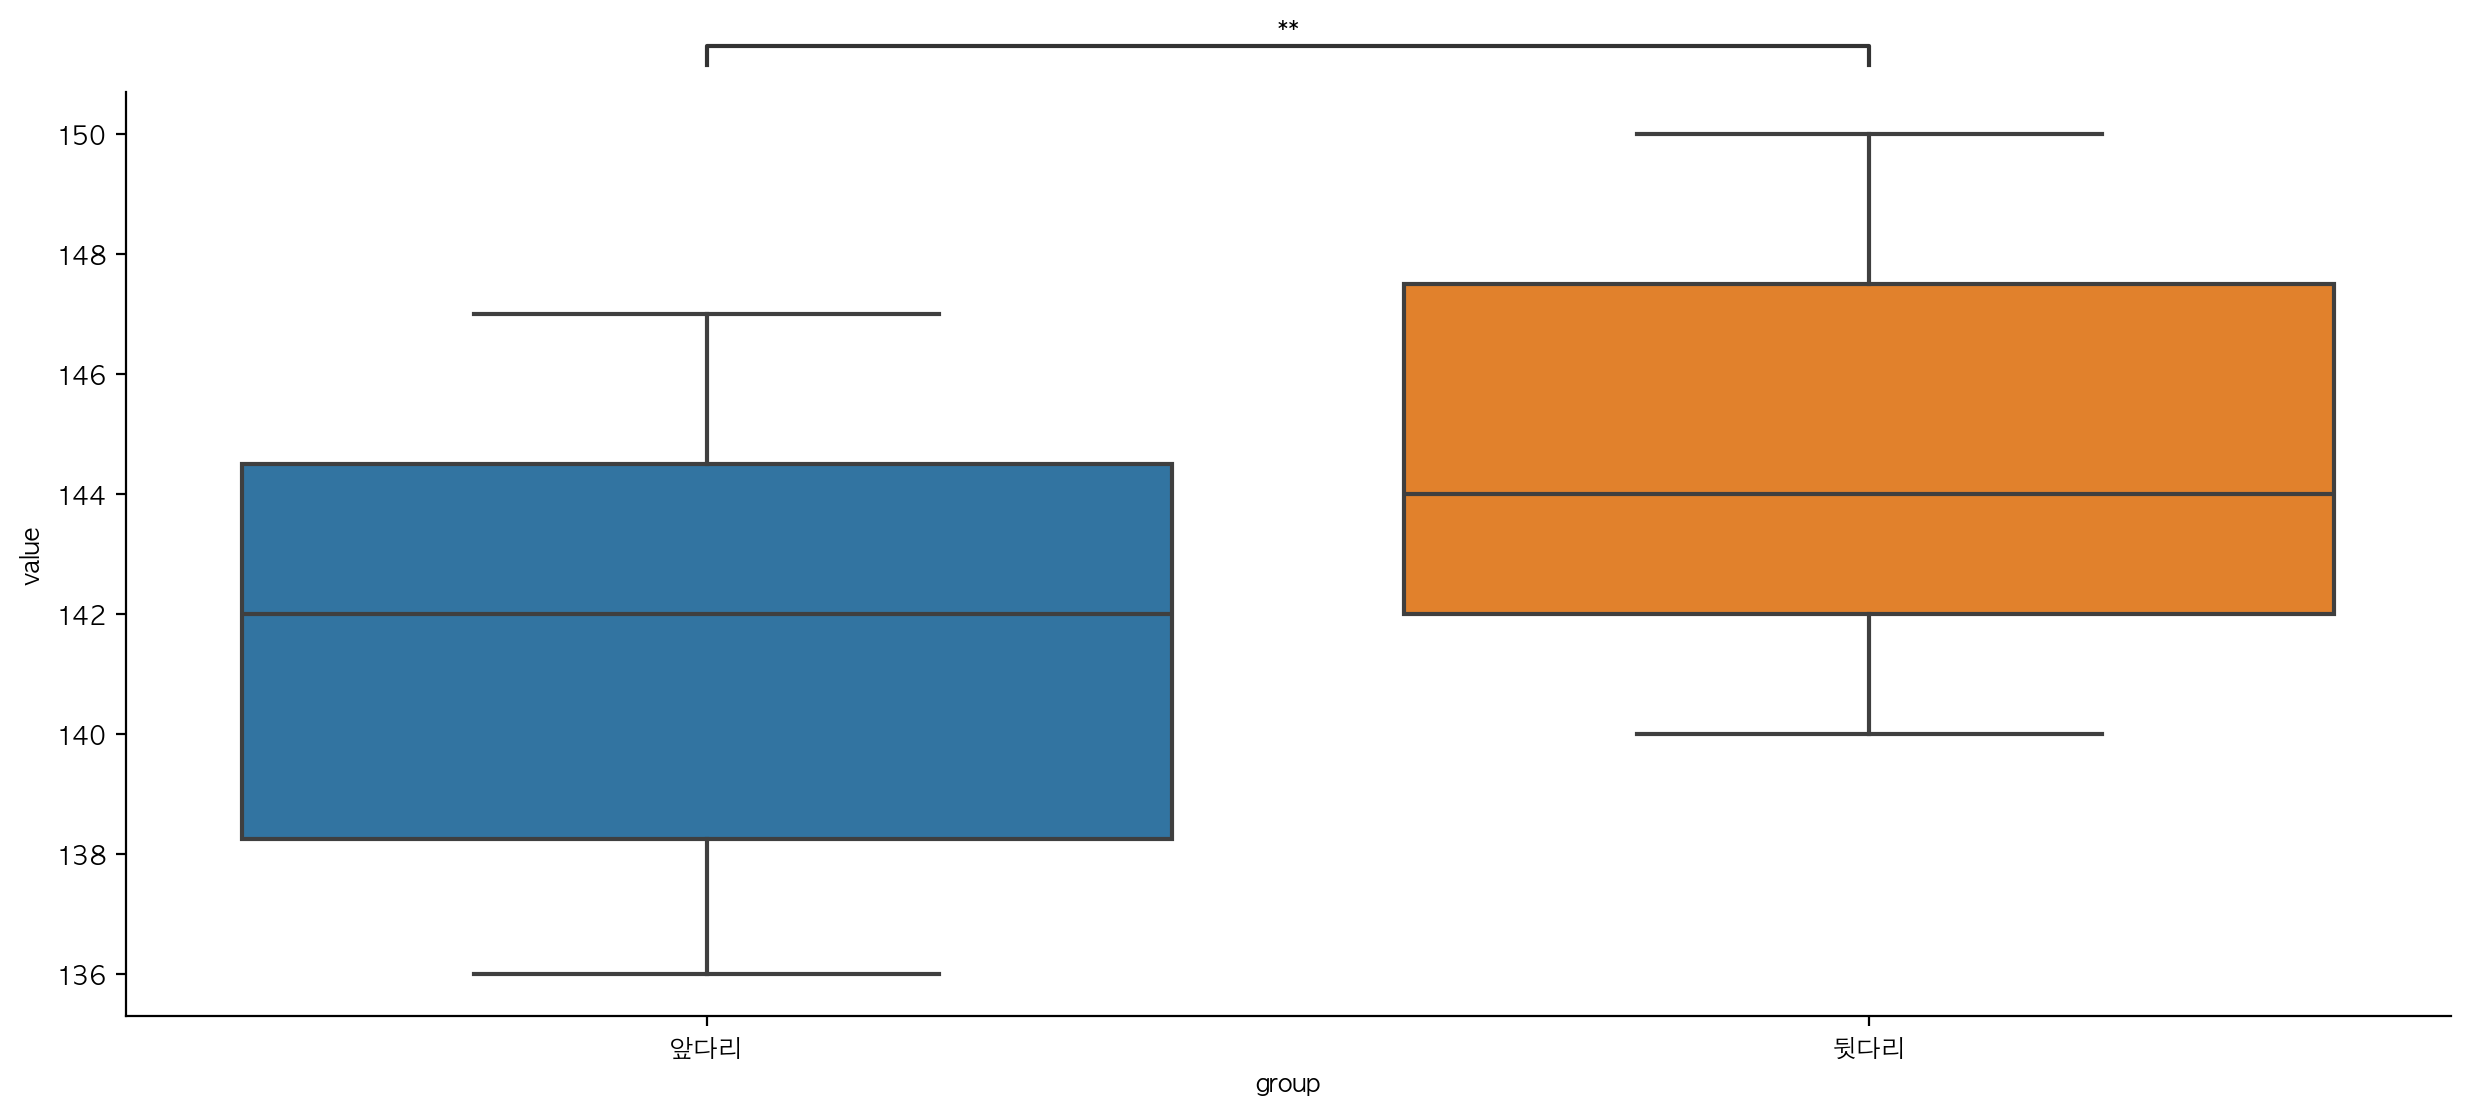

In [128]:
config = {
    "data": df,
    "x": "group",
    "y": "value",
    "pairs": [("앞다리", "뒷다리")],
    "test": "t-test_paired", # t-test_ind, t-test_paired, t-test_welch, Mann-Whitney, Mann-Whitney-gt, Mann-Whitney-ls, Levene, Wilcoxon, Kruskal
    "text_format": "star", # full, simple, star
    "loc": "outside" # outside, inside
}

plt.figure()
ax = sb.boxplot(data=config['data'], x=config['x'], y=config['y'])
ax.get_xaxis().axis_name

annotator = Annotator(ax, data=config['data'], x=config['x'], y=config['y'], pairs=config['pairs'])
annotator.configure(test=config['test'], text_format=config['text_format'], loc=config['loc'])
annotator.apply_and_annotate()

sb.despine()
plt.show()
plt.close()

## #03. 예제 (2) - 자동차 첨가제가 주행거리에 미치는 영향

다섯 종류의 새 차에 대하여 같은 종류의 차 두 대 중에서 한 대를 랜덤하게 선택하여 첨가제를 사용하고, 다른 한 대에는 첨가제를 사용하지 않고 같은 운전자가 같은 장소에서 운전한 결과 다음과 같은 자료를 얻었다.

첨가제를 사용하면 주행거리가 늘어난다고 할 수 있는지 유의수준 5%에서 검정하여 보라.

> 그룹A : 첨가제를 사용한 경우, 그룹B : 첨가제를 사용하지 않은 경우

### [1] 데이터 가져오기

In [6]:
origin = read_excel("https://data.hossam.kr/mldata/oil.xlsx")
origin

,그룹A,그룹B
0,13.2,11.8
1,13.1,13.9
2,16.3,12.1
3,14.9,10.5
4,14.2,9.3
5,16.1,16.3
6,15.1,15.1
7,13.6,12.3
8,15.8,11.6
9,14.2,8.4


### [2] 신뢰구간 확인

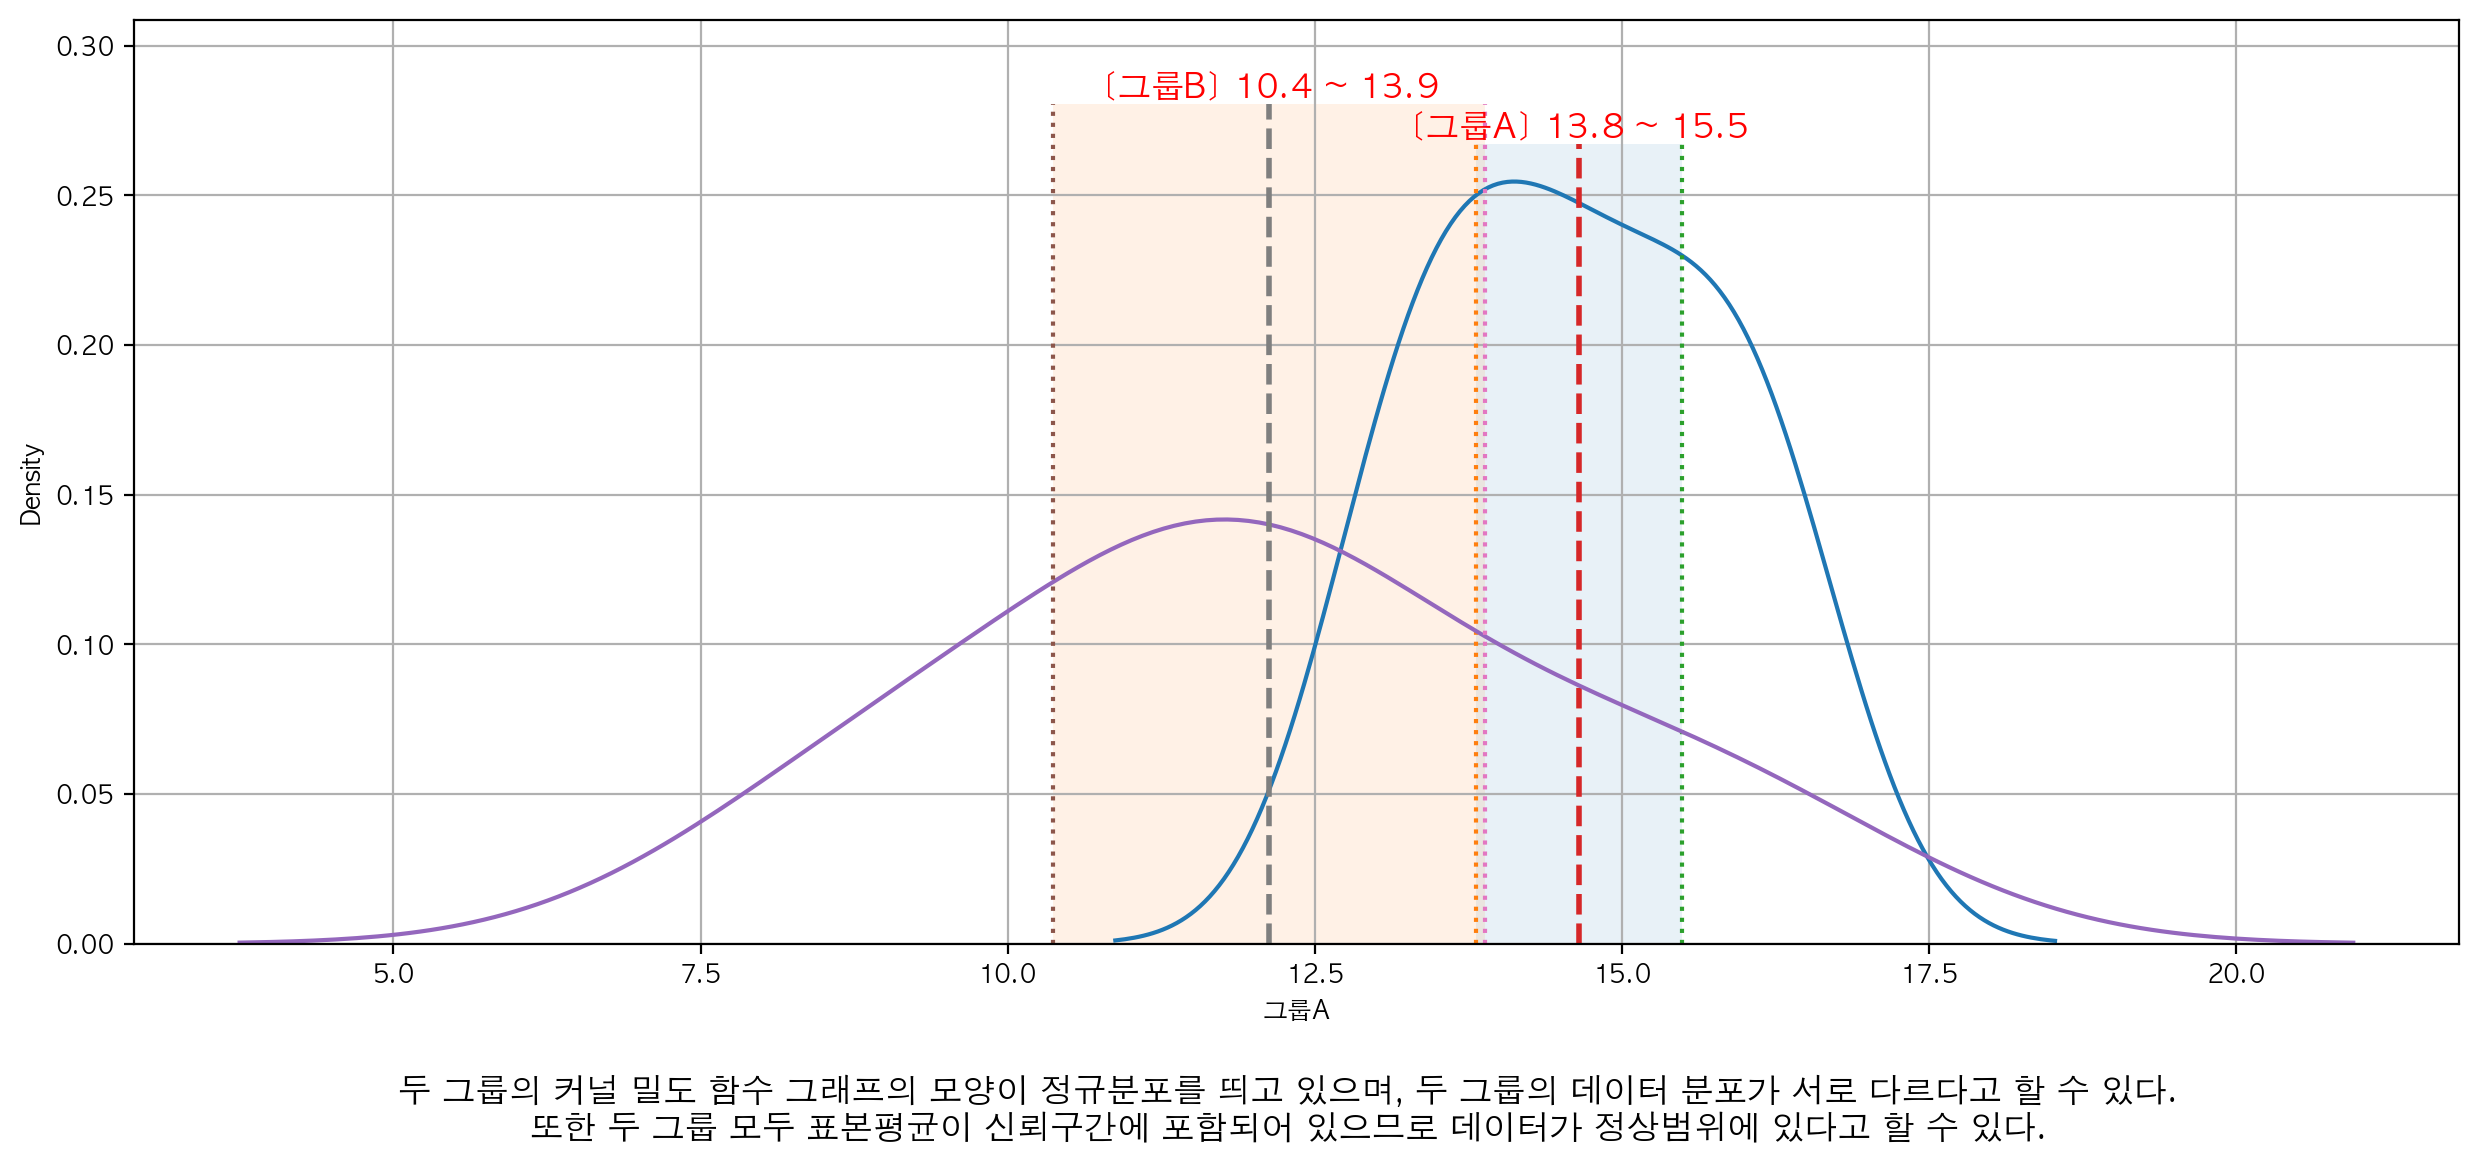

In [130]:
plt.figure()

for c in origin.columns:
    #print(c)
    
    data = origin[c]                                # 데이터만 추출
    max = data.max()                                # 최대값
    clevel = 0.95                                   # 신뢰수준
    dof = len(data) - 1                             # 자유도
    sample_mean = data.mean()                       # 표본평균
    sample_std = data.std(ddof=1)                   # 표본표준편차
    sample_std_error = sample_std / sqrt(len(data)) # 표본표준오차
    
    # 신뢰구간
    cmin, cmax = t.interval(clevel, dof, loc=sample_mean, scale=sample_std_error)

    sb.kdeplot(data=data)

    xmin, xmax, ymin, ymax = plt.axis()

    # 신뢰구간 그리기
    plt.plot([cmin, cmin], [0, ymax], linestyle=':')
    plt.plot([cmax, cmax], [0, ymax], linestyle=':')
    plt.fill_between([cmin, cmax], y1=0, y2=ymax, alpha=0.1)

    # 평균 그리기
    plt.plot([sample_mean, sample_mean], [0, ymax], linestyle='--', linewidth=2)

    plt.text(x=(cmax-cmin)/2+cmin,
            y=ymax,
            s="[%s] %0.1f ~ %0.1f" % (c, cmin, cmax),
            horizontalalignment="center",
            verticalalignment="bottom",
            fontdict={"size": 12, "color": "red"})

plt.ylim(0, ymax*1.1)

txt = """두 그룹의 커널 밀도 함수 그래프의 모양이 정규분포를 띄고 있으며, 두 그룹의 데이터 분포가 서로 다르다고 할 수 있다.
또한 두 그룹 모두 표본평균이 신뢰구간에 포함되어 있으므로 데이터가 정상범위에 있다고 할 수 있다."""

plt.figtext(0.51, 0, txt, wrap=True,
            verticalalignment="top", horizontalalignment="center",
            fontdict={"size": 12, "weight": "light"})

plt.grid()
plt.show()
plt.close()

### [3] 가설검정 가정 확인

#### (1) 정규성

In [131]:
for c in origin.columns:
    s, p = normaltest(origin[c])
    print("[{0}] statistic: {1:.3f}, p-value: {2:.3f}, 정규성 충족 여부: {3}".format(c, s, p, p > 0.05))

[그룹A] statistic: 1.804, p-value: 0.406, 정규성 충족 여부: True
[그룹B] statistic: 0.151, p-value: 0.927, 정규성 충족 여부: True


#### (2) 등분산성

In [132]:
normal_dist = True      # 정규성 만족 여부
data = origin.copy()    # 원본 데이터 복사
fields = list(map(lambda x: data[x], data.columns))

if normal_dist:
    n = "Bartlett"
    s, p = bartlett(*fields)
else:
    n = "Levene"
    s, p = levene(*fields)
    
print("{0} 검정: statistic: {1:.3f}, p-value: {2:.3f}, 등분산성 충족 여부: {3}".format(n, s, p, p > 0.05))

Bartlett 검정: statistic: 4.273, p-value: 0.039, 등분산성 충족 여부: False


> 데이터가 정규성을 만족하지만 등분산성은 만족하지 않는다.

### [4] 두 그룹의 주행거리가 차이가 있는지 검정

데이터가 등분산성을 만족하지 않을 경우 `mannwhitneyu` 함수를 사용하여 `Mann–Whitney U 검정`을 시행한다.

| 구분 | 수식 | 내용 |
|---|---|---|
| 그룹A의 주행거리 평균 | $\mu(A)$ | |
| 그룹B의 주행거리 평균 | $\mu(B)$ | |
| 귀무가설($H_0$) | $\mu(A) = \mu(A)$ | 그룹A와 그룹B의 주행거리에는 차이가 없다.<br/>즉, 실험에 사용된 첨가제는 주행거리에 영향을 주지 않는다. |
| 대립가설($H_1$) | $\mu(B) \neq \mu(B)$ | 그룹A와 그룹B의 주행거리에는 차이가 있다.<br/>즉, 실험에 사용된 첨가제는 주행거리에 영향을 준다. |

In [133]:
s, p = mannwhitneyu(origin['그룹A'], origin['그룹B'], alternative='two-sided')
"statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택".format(s, p, "대립" if p <= 0.05 else "귀무")

'statistic: 81.000, p-value: 0.021, 대립가설 채택'

> 대응표본 검정결과에서 p값이 `0.01`로 유의수준 `0.05`보다 작으므로 차이가 없다는 귀무가설을 기각하고 대립가설을 채택한다.
>
> 따라서 첨가제를 사용하는 경우 주행거리에 차이가 있다고 판단된다.

### [5] 그룹A의 주행거리가 그룹B의 심장계수보다 짧은지 검정


| 구분 | 수식 | 내용 |
|---|---|---|
| 귀무가설($H_0$) | $\mu(A) \geqq \mu(B)$ | 그룹A의 평균 주행거리는 그룹B의 평균 주행거리보다 짧지 않다. |
| 대립가설($H_1$) | $\mu(A) \lt \mu(B)$ | 그룹A의 평균 주행거리는 그룹B의 평균 주행거리보다 짧다. |

In [134]:
s, p = mannwhitneyu(origin['그룹A'], origin['그룹B'], alternative='less')
"statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택".format(s, p, "대립" if p <= 0.05 else "귀무")

'statistic: 81.000, p-value: 0.991, 귀무가설 채택'

> 대응표본 검정결과에서 p값이 `0.991`로 유의수준 `0.05`보다 크므로 첨가제를 넣은 A그룹의 주행거리가 첨가제를 넣지 않은 B그룹의 주행거리 보다 짧지 않다는 귀무가설을 기각할 수 없다.
> 
> 그러므로 실험에 사용된 첨가제는 주행거리를 감소시키지 않는다.

### [6] 그룹A의 주행거리가 그룹B의 주행거리보다 긴지 검정


| 구분 | 수식 | 내용 |
|---|---|---|
| 귀무가설($H_0$) | $\mu(A) \leqq \mu(B)$ | 그룹A의 주행거리는 그룹B의 주행거리보다 길지 않다. 첨가제는 주행거리를 늘리는데 효과가 없다. |
| 대립가설($H_1$) | $\mu(A) \gt \mu(B)$ | 그룹A의 주행거리는 그룹B의 주행거리보다 길다. 첨가제는 주행거리를 늘리는데 효과가 있다. |

In [135]:
s, p = mannwhitneyu(origin['그룹A'], origin['그룹B'], alternative='greater')
"statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택".format(s, p, "대립" if p <= 0.05 else "귀무")

'statistic: 81.000, p-value: 0.010, 대립가설 채택'

> 대응표본 검정결과에서 p값이 `0.010`으로 유의수준 `0.05`보다 작으므로 첨가제를 넣은 그룹의 주행거리가 첨가제를 넣지 않은 그룹의 주행거리보다 길지 않다는 귀무가설을 기각하고 대립가설을 채택한다.
>
> 즉, 첨가제를 넣은 A그룹의 주행거리가 더 길기 때문에 실험에 사용된 첨가제는 주행거리의 연장에 효과가 있다고 볼 수 있다.

### [7] 가설검정 시각화

In [136]:
df = melt(origin, var_name='group', value_name='value')
df

,group,value
0,그룹A,13.2
1,그룹A,13.1
2,그룹A,16.3
3,그룹A,14.9
4,그룹A,14.2
5,그룹A,16.1
6,그룹A,15.1
7,그룹A,13.6
8,그룹A,15.8
9,그룹A,14.2


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

그룹A vs. 그룹B: Mann-Whitney-Wilcoxon test two-sided, P_val:2.099e-02 U_stat=8.100e+01
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

그룹A vs. 그룹B: Mann-Whitney-Wilcoxon test smaller, P_val:9.914e-01 U_stat=8.100e+01
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

그룹A vs. 그룹B: Mann-Whitney-Wilcoxon test greater, P_val:1.049e-02 U_stat=8.100e+01


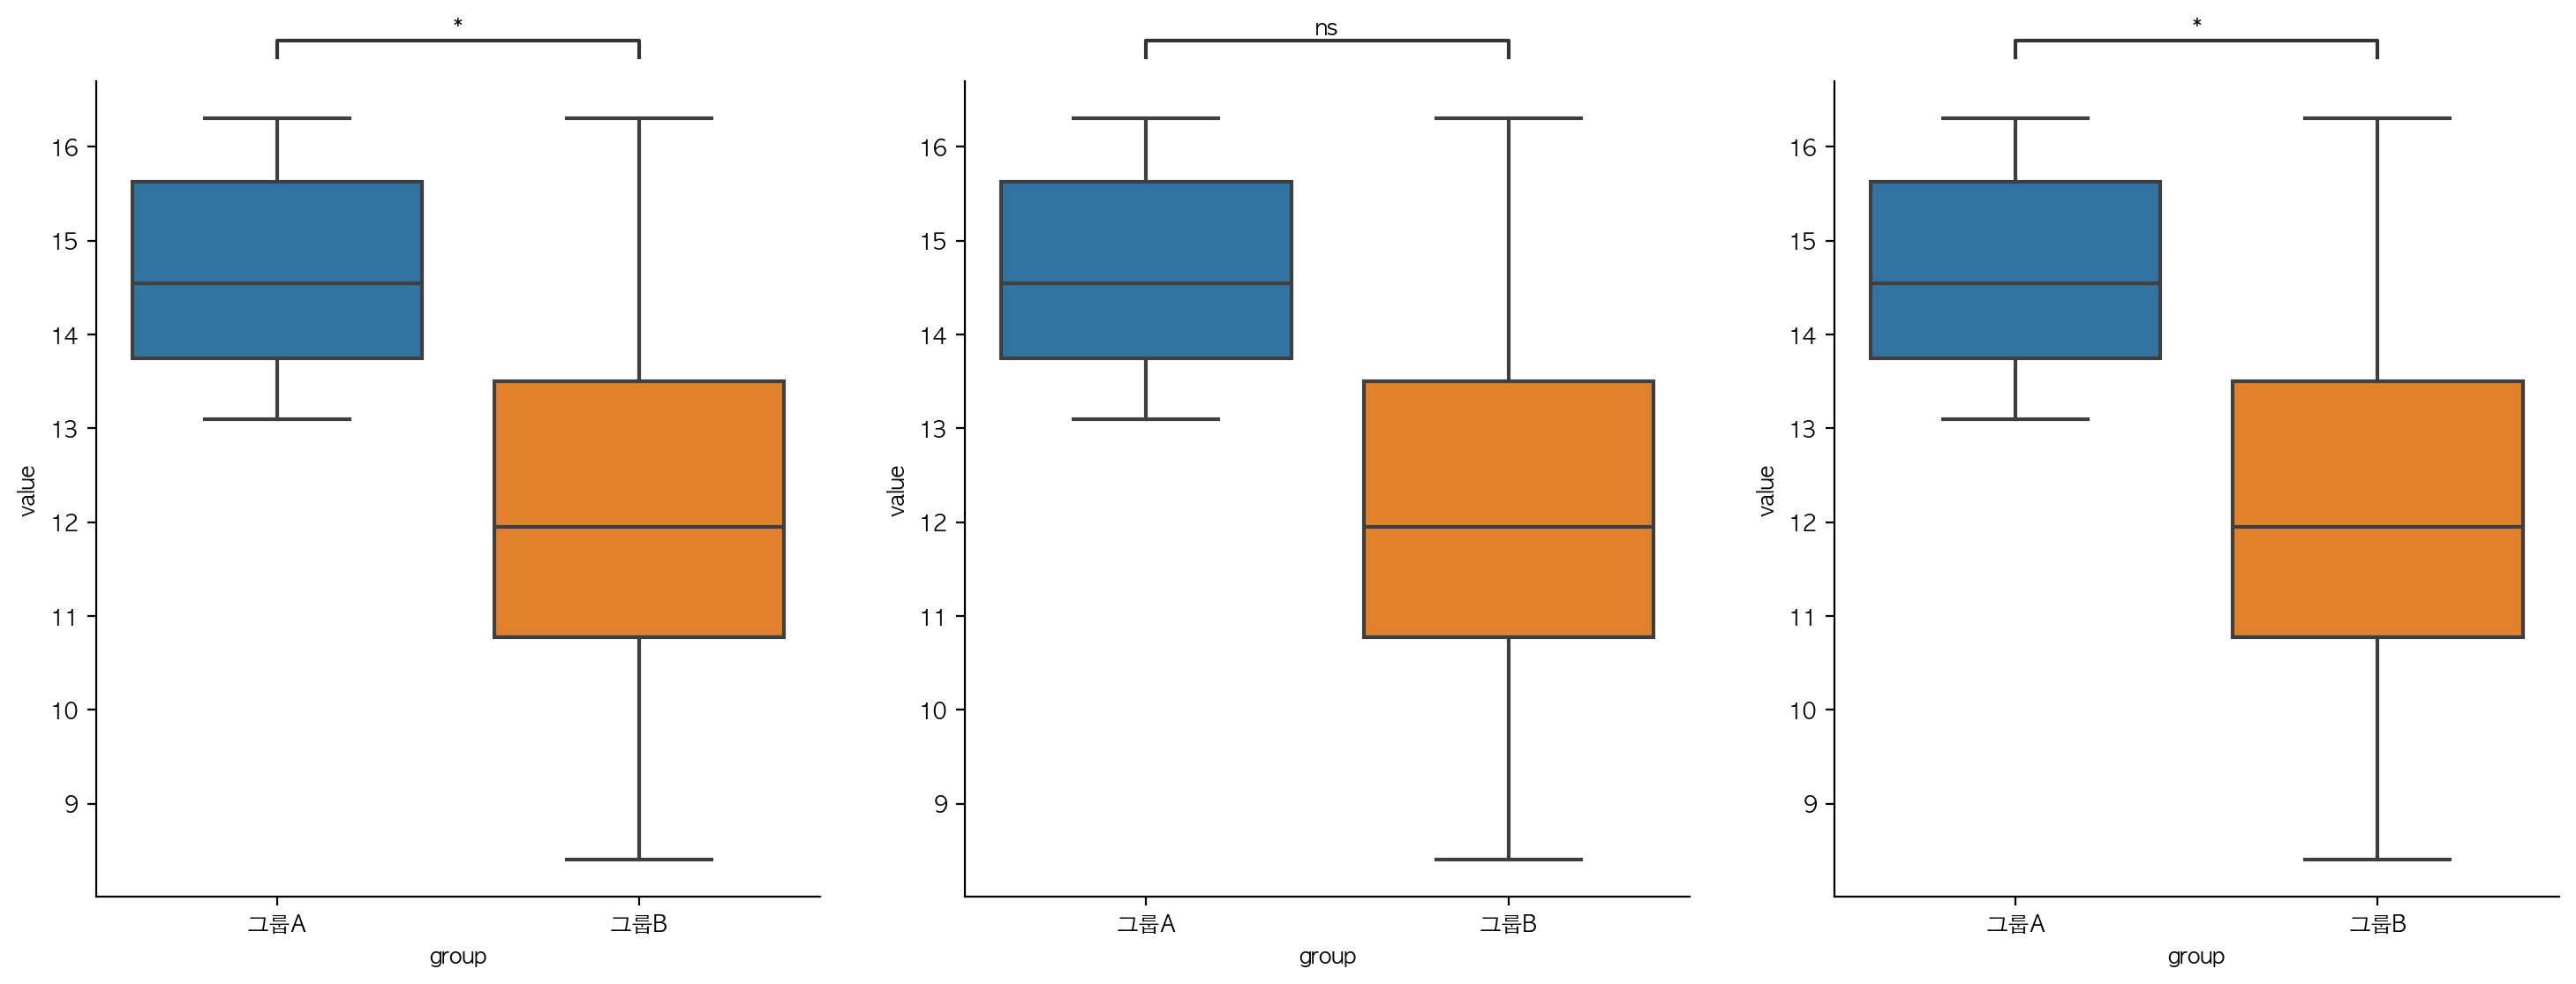

In [137]:
test = ['Mann-Whitney', 'Mann-Whitney-ls', 'Mann-Whitney-gt']

config = {
    "data": df,
    "x": "group",
    "y": "value",
    "pairs": [("그룹A", "그룹B")],
    "test": None,
    "text_format": "star",
    "loc": "outside"
}

fig, ax = plt.subplots(1, 3, figsize=(18, 6))

for i, v in enumerate(ax):
    config['test'] = test[i]
    
    k = sb.boxplot(ax=v, data=config['data'], x=config['x'], y=config['y'])
    v.get_xaxis().axis_name
    
    annotator = Annotator(k, data=config['data'], x=config['x'], y=config['y'], pairs=config['pairs'])
    annotator.configure(test=config['test'], text_format=config['text_format'], loc=config['loc'])
    annotator.apply_and_annotate()

    sb.despine(ax=v)
    
plt.show()
plt.close()